In [1]:
import UWGeodynamics as GEO
import numpy as np
import glucifer

loaded rc file /opt/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

velocity = 1 * u.centimeter / u.year
model_length = 100. * u.kilometer
bodyforce = 2700. * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2

GEO.scaling["[length]"] = KL
GEO.scaling["[time]"] = Kt
GEO.scaling["[mass]"] = KM

In [3]:
Model = GEO.Model(
    elementRes=(400 , 80),
    minCoord=(0. * u.kilometer, -8 * u.kilometer),
    maxCoord=(100. * u.kilometer, 12. * u.kilometer),
    gravity=(0.0, -9.81 * u.meter / u.second**2))
Model.outputDir = "rf2v0.1hi"

Model.minViscosity = 1e18 * u.pascal * u.second
Model.maxViscosity = 1e25 * u.pascal * u.second
!mkdir "rf2v0.1hi"

mkdir: cannot create directory 'rf2v0.1hi': File exists


In [4]:
stickyAirLayer = Model.add_material(
    name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=0. * u.kilometer))


plTop = stickyAirLayer.bottom
plBot = -7 * u.kilometer
plasticLayerThickness = plTop - plBot

plasticLayerheight = 0.5 * u.kilometer
plasticLayerNos = plasticLayerThickness / plasticLayerheight
plasticLayers = [Model.add_material(name='Plastic' + str(i),
       shape=GEO.shapes.Layer(top=plTop - i * plasticLayerheight,
       bottom=plTop - (i * plasticLayerheight + plasticLayerheight)))
       for i in range(plasticLayerNos)]
box = GEO.shapes.Box(top=-3.* u.kilometer, bottom=-4.*u.kilometer,
                       minX=80.*u.kilometer, maxX=Model.length)
#frictLayer1=Model.add_material(
    #name="intermediate_Frictional_Layer",
    #shape=box)
frictionalBasalLayer = Model.add_material(
    name="Basal_Frictional_Layer",
    shape=GEO.shapes.Layer(
        top=plasticLayers[-1].bottom, bottom=plasticLayers[-1].bottom-.5 * u.kilometer))
rigidBase = Model.add_material(
    name="Rigid_Base",
    shape=GEO.shapes.Layer(top=frictionalBasalLayer.bottom, bottom=Model.bottom))
sediment = Model.add_material(name="Sediment")


In [5]:
for plasticLayer in plasticLayers:
    plasticLayer.density = 2700. * u.kilogram / u.metre**3
#frictLayer1.density = 2700. * u.kilogram / u.metre**3
frictionalBasalLayer.density = 2700. * u.kilogram / u.metre**3
rigidBase.density = 2700. * u.kilogram / u.metre**3
sediment.density = 2700. * u.kilogram / u.metre**3


In [6]:
stickyAirLayer.viscosity = GEO.ConstantViscosity(1e18 * u.pascal * u.second)
for plasticLayer in plasticLayers:
    plasticLayer.viscosity = 1e24 * u.pascal * u.second
#frictLayer1.viscosity = 1e24 * u.pascal * u.second
frictionalBasalLayer.viscosity = 1e24 * u.pascal * u.second
rigidBase.viscosity = GEO.ConstantViscosity(1e25 * u.pascal * u.second)
sediment.viscosity = GEO.ConstantViscosity(1e24 * u.pascal * u.second)


In [7]:
for plasticLayer in plasticLayers:
    plasticLayer.plasticity = GEO.DruckerPrager(
        cohesion=20. * u.megapascal,
        # cohesionAfterSoftening=4. * u.megapascal,
        frictionCoefficient=np.tan(np.radians(25.0)),
        # frictionAfterSoftening=np.tan(np.radians(15.0)),
        # epsilon1=0.01,
        # epsilon2=0.06
    )


#frictLayer1.plasticity = GEO.DruckerPrager(
    #cohesion=0.001 * u.pascal,
    ##cohesionAfterSoftening=0.001 * u.pascal,
    #frictionCoefficient=np.tan(np.radians(10.0)),
    ##frictionAfterSoftening=np.tan(np.radians(15.0)),
    ##epsilon1=0.01,
    ##epsilon2=0.01
#)

frictionalBasalLayer.plasticity = GEO.DruckerPrager(
    cohesion=0.001 * u.pascal,
    #cohesionAfterSoftening=0.001 * u.pascal,
    frictionCoefficient=np.tan(np.radians(10.0)),
    #frictionAfterSoftening=np.tan(np.radians(15.0)),
    #epsilon1=0.01,
    #epsilon2=0.01
)


sediment.plasticity = GEO.DruckerPrager(
    cohesion=20. * u.megapascal,
    #cohesionAfterSoftening=4. * u.megapascal,
    frictionCoefficient=np.tan(np.radians(25.0)),
    #frictionAfterSoftening=np.tan(np.radians(15.0)),
    #epsilon1=0.01,
    #epsilon2=0.6
)


In [8]:
Model.save()

In [9]:
taper_start = 0.4 * (plasticLayers[0].top - plasticLayers[-1].bottom)
bottom_conditions = [(Model.x < GEO.nd(taper_start),
                      Model.x * GEO.nd(-velocity / taper_start)),
                     (True, GEO.nd(-velocity))]

conditions = [(Model.y <= GEO.nd(rigidBase.top), GEO.nd(-velocity)),
              (True, GEO.nd(0. * u.centimeter / u.year))]

# taper_start = 0.4 * (plasticLayer.top - plasticLayer.bottom)
# botom_conditions = [(Model.x < GEO.nd(taper_start),
#                      Model.x * GEO.nd(-velocity / taper_start)),
#       np              (True, GEO.nd(-velocity))]



In [10]:
VelocityBcs = Model.set_velocityBCs(
    left=[conditions, 0.],
    right=[-velocity, None],
    top=[None, None],
    bottom=[-velocity, 0.])


In [11]:
GEO.rcParams["solver"] = "lu"
GEO.rcParams["penalty"] = 1e6
GEO.rcParams["nonlinear.tolerance"] = 1e-3
GEO.rcParams["nonlinear.max.iterations"]=2
GEO.rcParams["initial.nonlinear.tolerance"]=1e-4
GEO.rcParams["initial.nonlinear.max.iterations"]=2
GEO.rcParams["initial.nonlinear.max.iterations"]=2

Model.init_model()

In [12]:
Model.surfaceProcesses = GEO.surfaceProcesses.BasicHillSlopeDiffsuion2d(
    Model=Model,
    airIndex=stickyAirLayer.index,
    sedimentIndex=sediment.index,
    diffusivity=GEO.nd(1e-8 * u.metre**2 / u.second))

In [13]:
fnSize = 2

# figSize = (int(Model.elementRes[0] * 4.5 + 10),
#            int(Model.elementRes[1] * 4.5 + 150))

figSize=(900,250)

In [14]:
layeredColours=int(plasticLayerNos/2)*'#425e6a salmon '+'tan #3A3A3A #00a8a8'


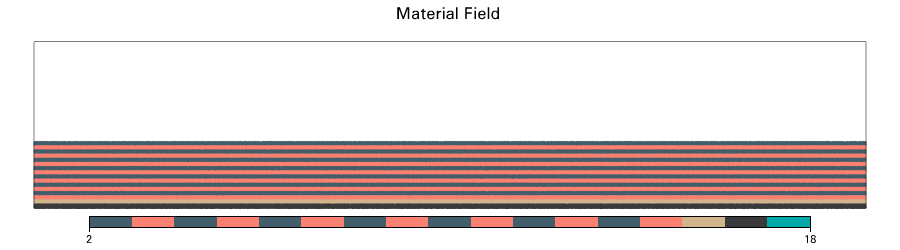


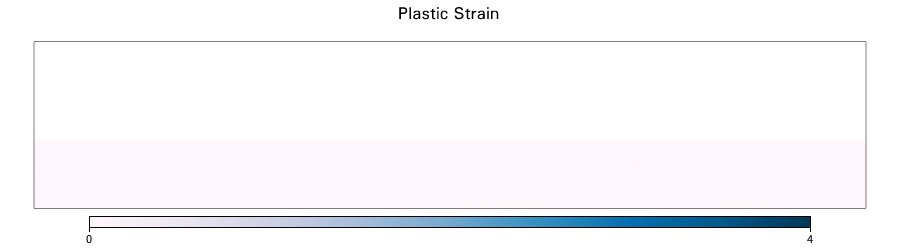


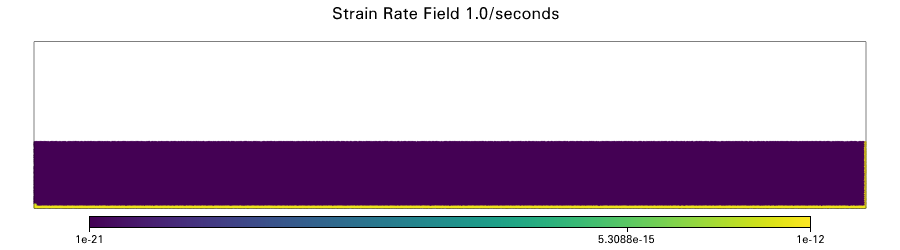


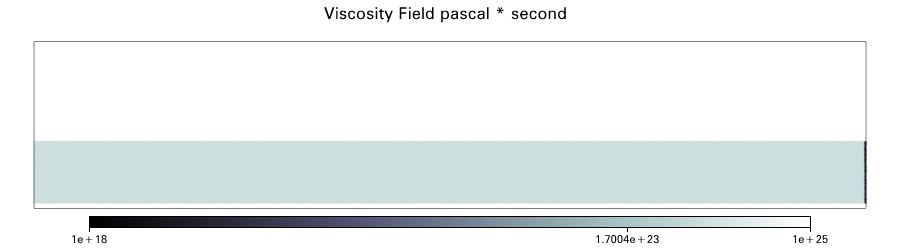


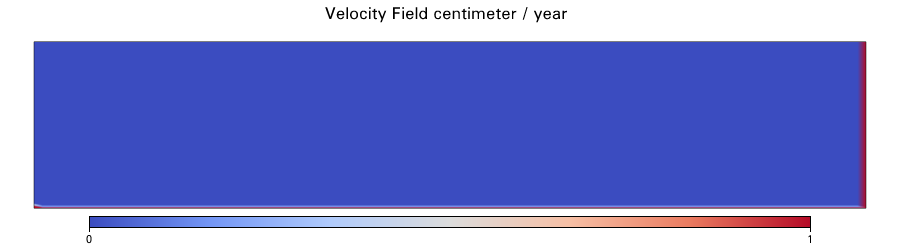


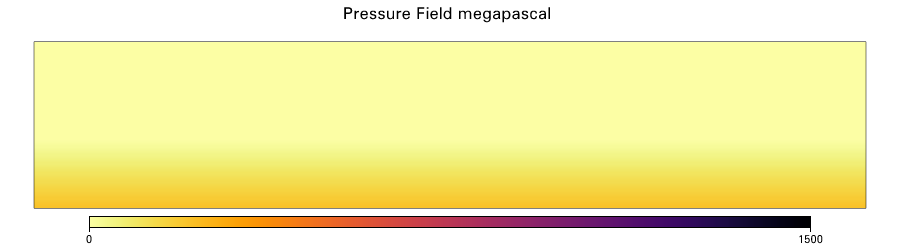

In [15]:

figMt = Model.plot.material(
    figsize=figSize,
    fn_size=fnSize,
    colours=layeredColours,
    valueRange=[plasticLayers[0].index, sediment.index],
    fn_mask=Model.materialField > stickyAirLayer.index)

figPs = Model.plot.plasticStrain(
    figsize=figSize,
    colours=lavavu.matplotlib_colourmap("PuBu"),
    fn_size=fnSize,
    fn_mask=Model.materialField > stickyAirLayer.index,
    valueRange=[0, 4])

figSr = glucifer.Figure(
    figsize=figSize,
    quality=3,
    title="Strain Rate Field 1.0/seconds",
    boundingBox=((GEO.nd(Model.minCoord[0]), GEO.nd(Model.minCoord[1])),
                 (GEO.nd(Model.maxCoord[0]), GEO.nd(Model.maxCoord[1]))))

figSr.Points(
    Model.swarm,
    Model._strainRate_2ndInvariant * GEO.Dimensionalize(
        1.0, 1. / u.seconds).magnitude,
    logScale=True,
    colours=lavavu.matplotlib_colourmap("viridis"),
    valueRange=[1e-21, 1e-12],
    fn_mask=Model.materialField > stickyAirLayer.index,
    fn_size=fnSize)
figSr.show()

figVs = Model.plot.viscosity(
    figsize=figSize,
    colours=lavavu.matplotlib_colourmap("bone"),
    fn_size=fnSize,
    valueRange=[1e18, 1e25],
    fn_mask=Model.materialField > stickyAirLayer.index)

figVm = Model.plot.velocityField(
    figsize=figSize,
    colours='coolwarm',
    arrowlength=0.0075,
    arrownorm=.75,
    arrowres=(32,16,16))


figPr = Model.plot.pressureField(
    figsize=figSize,
    valueRange=[0, 1.5e3],
    colours=lavavu.matplotlib_colourmap("inferno_r"),
    units=u.megapascal)


In [16]:
stepModel = 0


def saveFigures():
    global stepModel

    if (stepModel % 1 == 0):
        figMt.save(
            Model.outputDir + '/Material_' + str(stepModel).zfill(4) + '.png')
        figVs.save(
            Model.outputDir + '/Viscosity_' + str(stepModel).zfill(4) + '.png')
        figPs.save(Model.outputDir + '/PlasticStrain_' +
                   str(Model.step).zfill(4) + '.png')
        figSr.save(
            Model.outputDir + '/strainRate' + str(stepModel).zfill(4) + '.png')
        figVm.save(
            Model.outputDir + '/Velocity' + str(stepModel).zfill(4) + '.png')

    if (stepModel % 10 == 0):
        figPr.save(
            Model.outputDir + '/Pressure' + str(stepModel).zfill(4) + '.png')

#    np.save(Model.outputDir+'/'+str(stepModel).zfill(4) + 'gridt',Model.surfaceProcesses.gridt)

    stepModel += 1


saveFigures()
Model.postSolveHook = saveFigures


In [ ]:
Model.run_for(0.01 * u.megayears, dt=0.005*u.megayears, checkpoint_interval=.25 * u.megayears)

In [68]:
X=figVm.Points(Model.swarm,Model.materialField,fn_size=3,fn_mask=Model.materialField <= stickyAirLayer.index,colours='white white')

In [67]:
figVm.objects.remove(figVm.objects[-1])

In [69]:
X.colourBar['colourbar']=0

In [74]:
vc=figVm.objects[0].colourBar


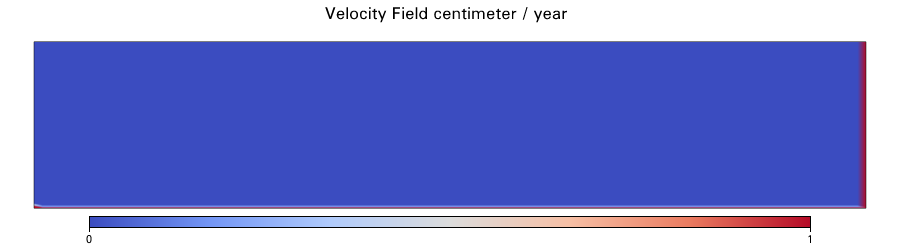

In [80]:

figVm2 = Model.plot.velocityField(figsize=figSize, colours='coolwarm',
                                 arrowlength=0.0075, arrownorm=.75,
                                 arrowres=(32, 16,
                                 16))
figVm2.Points(Model.swarm,
        Model.materialField, fn_size=3, fn_mask=Model.materialField
        <= stickyAirLayer.index, colours='white white'
        ).colourBar['colourbar'] = 0


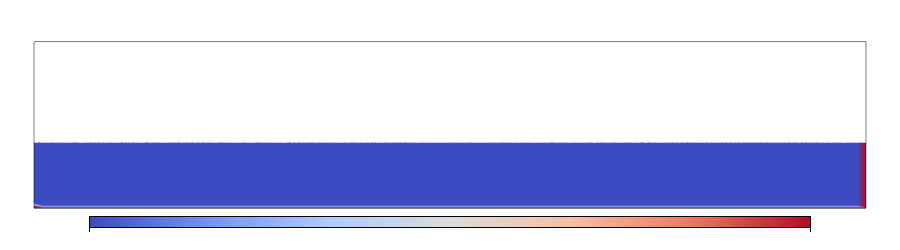

In [ ]:
figVm2